# IMDB

In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
from fastai.text import *

In [3]:
pwd

'/home/jupyter/tutorials/fastai/course-v3/nbs/dl1'

## Preparing the data

First let's download the dataset we are going to study. The [dataset](http://ai.stanford.edu/~amaas/data/sentiment/) has been curated by Andrew Maas et al. and contains a total of 100,000 reviews on IMDB. 25,000 of them are labelled as positive and negative for training, another 25,000 are labelled for testing (in both cases they are highly polarized). The remaning 50,000 is an additional unlabelled data (but we will find a use for it nonetheless).

We'll begin with a sample we've prepared for you, so that things run quickly before going over the full dataset.

In [4]:
#path = untar_data(URLs.IMDB_SAMPLE)
path = Path('/home/jupyter/tutorials/data')
path
for i in range(1,4):
    print(i)

1
2
3


In [5]:
t=(pd.read_csv(path/"FourYears_judgement_label.csv"))
t.head()


,label,Facts
0,Overruled,['Page 1Non-ReportableIN THE SUPREME COURT OF ...
1,Overruled,['']
2,Overruled,['Page 1Non-ReportableIN THE SUPREME COURT OF ...
3,Overruled,['']
4,Overruled,['']


In [6]:
d=np.where(t.applymap(lambda x: x == "['']"))
t = t.drop(t[t.Facts == "['']" ].index)
#len(d[1])
t.count()

label    3679
Facts    3679
dtype: int64

In [32]:
t.iloc[3387,1]

"['1REPORTABLE    IN THE SUPREME COURT OF INDIA     CRIMINAL APPELLATE JURISDICTION      CRIMINAL APPEAL NO. 40 OF 2007PADMINI MAHENDRABHAI GADDA                       … APPELLANTVERSUSSTATE OF GUJARAT                    … RESPONDENTJUDGMENTN.V. RAMANA, J.1.Aggrieved by the judgment and order, dated 4th October, 2006,passed by the High Court of Gujarat at Ahmadabad inCriminal Appeal No. 833 of 1997 and Crl.M.A. No. 1121 of1998 in Crl.A. No. 833 of 1997, the appellant is before thisCourt.2.The facts of the case in a nutshell as presented by theprosecution, are that the appellant herein and Mahendrabhai(deceased) had love marriage in the year 1981 and they wereblessed with two daughters. The deceased was running healthclubs in the city of Ahmedabad in the name and style of P.M.Health Club at two different locations; one at Naranpura and2the other at Ambawadi.  Accused No.1 i.e. Kishore Thakkarwas employed by the deceased to work at Naranpura location.With passage of time, the appellant (

In [ ]:
#cont=(pd.read_csv(path/"consti.csv"))
#cont.columns = ["Facts"]
#cont["label"]="Allowed"
#cont=cont[["label","Facts"]]
#cont.tail()

#IPC=(pd.read_csv(path/"IPC.csv"))
#IPC = IPC.insert(0,'label','Allowed', True)
#IPC.columns = ["Facts"]
#IPC["label"]="Allowed"
#IPC=IPC[["label","Facts"]]
IPC.tail()

In [ ]:
t=t.append(cont,ignore_index=True)

In [ ]:
#len(pd.read_csv(path/'011018_311218output_judgement_label.csv'))
fout=open(path/"OneYear011018_301019_judgement_label.csv","a")
# first file:
for line in open(path/"010719_301019output_judgement_label.csv"):
    fout.write(line)
# now the rest:    
for num in range(2,201):
    f = open(path/(next((*'output_judgement_label.csv'))))
    f.next() # skip the header
    for line in f:
         fout.write(line)
    f.close() # not really needed
fout.close()

# It only contains one csv file, let's have a look at it.

In [5]:
df = pd.read_csv(path/'FourYears_judgement_label.csv')
df = df[['label','Facts']]
df.head()

,label,Facts
0,Overruled,['Page 1Non-ReportableIN THE SUPREME COURT OF ...
1,Overruled,['']
2,Overruled,['Page 1Non-ReportableIN THE SUPREME COURT OF ...
3,Overruled,['']
4,Overruled,['']


In [6]:
#df=np.where(df.applymap(lambda x: x == "['']"))
df = df.drop(df[df.Facts == "['']" ].index)

In [7]:
df.count()

label    3679
Facts    3679
dtype: int64

It contains one line per review, with the label ('negative' or 'positive'), the text and a flag to determine if it should be part of the validation set or the training set. If we ignore this flag, we can create a DataBunch containing this data in one line of code:

In [ ]:
data_lm = TextDataBunch.from_csv(path, 'OneYear011018_301019_judgement_label.csv',0.2)

By executing this line a process was launched that took a bit of time. Let's dig a bit into it. Images could be fed (almost) directly into a model because they're just a big array of pixel values that are floats between 0 and 1. A text is composed of words, and we can't apply mathematical functions to them directly. We first have to convert them to numbers. This is done in two differents steps: tokenization and numericalization. A `TextDataBunch` does all of that behind the scenes for you.

Before we delve into the explanations, let's take the time to save the things that were calculated.

In [ ]:
data_lm.save()

In [ ]:
help(TextDataBunch)

Next time we launch this notebook, we can skip the cell above that took a bit of time (and that will take a lot more when you get to the full dataset) and load those results like this:

In [ ]:
data_lm.show_batch(ds_type=DatasetType.Valid)

In [ ]:
type(data_lm)

In [ ]:
data = load_data(path)

### Tokenization

The first step of processing we make the texts go through is to split the raw sentences into words, or more exactly tokens. The easiest way to do this would be to split the string on spaces, but we can be smarter:

- we need to take care of punctuation
- some words are contractions of two different words, like isn't or don't
- we may need to clean some parts of our texts, if there's HTML code for instance

To see what the tokenizer had done behind the scenes, let's have a look at a few texts in a batch.

In [ ]:
#data = TextClasDataBunch.from_csv(path, '010719_301019output_judgement_label.csv')
data_lm.show_batch()
#len(data_lm)

The texts are truncated at 100 tokens for more readability. We can see that it did more than just split on space and punctuation symbols: 
- the "'s" are grouped together in one token
- the contractions are separated like this: "did", "n't"
- content has been cleaned for any HTML symbol and lower cased
- there are several special tokens (all those that begin by xx), to replace unknown tokens (see below) or to introduce different text fields (here we only have one).

### Numericalization

Once we have extracted tokens from our texts, we convert to integers by creating a list of all the words used. We only keep the ones that appear at least twice with a maximum vocabulary size of 60,000 (by default) and replace the ones that don't make the cut by the unknown token `UNK`.

The correspondance from ids to tokens is stored in the `vocab` attribute of our datasets, in a dictionary called `itos` (for int to string).

In [ ]:
data_lm.vocab.itos[:10]

And if we look at what a what's in our datasets, we'll see the tokenized text as a representation:

In [ ]:
data_lm.train_ds[0][0]

But the underlying data is all numbers

In [ ]:
data_lm.train_ds[0][0].data[:10]

### With the data block API

We can use the data block API with NLP and have a lot more flexibility than what the default factory methods offer. In the previous example for instance, the data was randomly split between train and validation instead of reading the third column of the csv.

With the data block API though, we have to manually call the tokenize and numericalize steps. This allows more flexibility, and if you're not using the defaults from fastai, the various arguments to pass will appear in the step they're revelant, so it'll be more readable.

In [ ]:
data = (TextList.from_csv(path, 'texts.csv', cols='text')
                .split_from_df(col=2)
                .label_from_df(cols=0)
                .databunch())

## Language model

Note that language models can use a lot of GPU, so you may need to decrease batchsize here.

In [8]:
bs=16

Now let's grab the full dataset for what follows.

In [ ]:
pathtest = untar_data(URLs.WT103)
path.ls()

In [ ]:
#(path/'train').ls()
type(URLs)

The reviews are in a training and test set following an imagenet structure. The only difference is that there is an `unsup` folder on top of `train` and `test` that contains the unlabelled data.

We're not going to train a model that classifies the reviews from scratch. Like in computer vision, we'll use a model pretrained on a bigger dataset (a cleaned subset of wikipedia called [wikitext-103](https://einstein.ai/research/blog/the-wikitext-long-term-dependency-language-modeling-dataset)). That model has been trained to guess what the next word is, its input being all the previous words. It has a recurrent structure and a hidden state that is updated each time it sees a new word. This hidden state thus contains information about the sentence up to that point.

We are going to use that 'knowledge' of the English language to build our classifier, but first, like for computer vision, we need to fine-tune the pretrained model to our particular dataset. Because the English of the reviews left by people on IMDB isn't the same as the English of wikipedia, we'll need to adjust the parameters of our model by a little bit. Plus there might be some words that would be extremely common in the reviews dataset but would be barely present in wikipedia, and therefore might not be part of the vocabulary the model was trained on.

This is where the unlabelled data is going to be useful to us, as we can use it to fine-tune our model. Let's create our data object with the data block API (next line takes a few minutes).

In [ ]:
data_lm = (TextList.from_folder(path)
           #Inputs: all the text files in path
            .filter_by_folder(include=['train', 'test', 'unsup']) 
           #We may have other temp folders that contain text files so we only keep what's in train and test
            .split_by_rand_pct(0.1)
           #We randomly split and keep 10% (10,000 reviews) for validation
            .label_for_lm()           
           #We want to do a language model so we label accordingly
            .databunch(bs=bs))
data_lm.save('data_lm.pkl')

In [9]:
data_lmT = (TextList.from_df(df = df, cols=1) 
             .split_by_rand_pct(0.1) 
             .label_for_lm()
             .databunch(bs=bs))

We have to use a special kind of `TextDataBunch` for the language model, that ignores the labels (that's why we put 0 everywhere), will shuffle the texts at each epoch before concatenating them all together (only for training, we don't shuffle for the validation set) and will send batches that read that text in order with targets that are the next word in the sentence.

The line before being a bit long, we want to load quickly the final ids by using the following cell.

In [14]:
data_lmT.save(path/'data_lmT_LMC.pkl')

In [ ]:
help(TextList)

In [6]:
data_lmT = load_data(path, 'data_lmT_LMC.pkl', bs=bs)

In [15]:
data_lmT.show_batch()

idx,text
0,"xxup rao , xxunk xxmaj electricity xxmaj supply xxmaj company xxunk ) , the xxmaj appellant herein , is a distribution licensee . m / s. xxup amr xxmaj power xxmaj private xxmaj limited , the xxmaj first xxmaj respondentherein , is a renewable power generator which has xxunk is operating a xxunk xxup mw run of the river mini xxunk xxunk project in the xxmaj state of xxmaj karnataka"
1,"the xxmaj state xxmaj government onthe subject without the xxmaj advocate xxmaj general in turn xxunk selection process , assessing inter se merit on an xxunk or maintaining any record of any such process havingbeen undertaken . xxmaj the affidavits also do not rule out thepossibility of the xxmaj governments themselves xxunk over and above those recommended by theadvocate xxmaj general on the basis of what the xxmaj affidavit of"
2,"- f - xxunk - f - xxunk was submitted , that there was no legitimate basis for recording such a xxunk was also the contention of learned counsel , that the judgment rendered bythe xxmaj high xxmaj court , rightly negated the financial impact of ‘ the 1999 xxmaj scheme’ , becausein terms of the conclusions drawn in the judgment , the same would not be applicableto future employees"
3,"furnished , declarant is duty bound to furnish it correctly and any suppression ofmaterial facts or submitting false information , may by itself lead to termination ofhis services or cancellation of candidature in an appropriate case . xxmaj however , in acriminal case incumbent has not been acquitted and case is pending trial , xxunk well be justified in not appointing such an incumbent or in terminating theservices as conviction"
4,"principal xxmaj act by a xxmaj state xxmaj legislature or a 31page xxunk xxmaj court before the commencement of this xxmaj act shall , except insofar as such amendment or provision is consistent with the provisions of the principal xxmaj act as amended by this xxmaj act , stand repealed . ” ( xxmaj noticed again for xxunk language of xxmaj section 97(1 ) of the xxmaj amendment xxmaj act"


We can then put this in a learner object very easily with a model loaded with the pretrained weights. They'll be downloaded the first time you'll execute the following line and stored in `~/.fastai/models/` (or elsewhere if you specified different paths in your config file).

In [7]:
learn = language_model_learner(data_lmT, AWD_LSTM, drop_mult=0.3)

In [ ]:
learn.lr_find()

In [ ]:
learn.recorder.plot(skip_end=15)

In [14]:
learn.fit_one_cycle(1, 1e-2, moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,time
0,3.495407,3.639196,0.383546,34:40


In [15]:
learn.save(path/'fit_head_FD_LMC')

In [ ]:
learn.load(path/'fit_head_FD_LMC');

To complete the fine-tuning, we can then unfeeze and launch a new training.

In [9]:
learn.unfreeze()

In [12]:
learn.fit_one_cycle(1, 1e-3, moms=(0.8,0.7))
#46.26

epoch,train_loss,valid_loss,accuracy,time
0,2.670135,2.941345,0.465095,34:49


In [13]:
learn.save(path/'fine_tuned_FD_LMC')
#data_lmT.save(path/'data_lmT.pkl')
#44.6

How good is our model? Well let's try to see what it predicts after a few given words.

In [8]:
learn.load(path/'fine_tuned_FD_LMC');


In [14]:
TEXT = "THE APPEAL IS ALLOWED BECAUSE"
N_WORDS = 40
N_SENTENCES = 2

In [15]:
print("\n".join(learn.predict(TEXT, N_WORDS, temperature=0.75) for _ in range(N_SENTENCES)))

THE APPEAL IS ALLOWED BECAUSE OF ACQUITTAL OF THE JUDGES OF THE HIGH COURT OF INDIACIVIL APPELLATE JURISDICTIONCIVIL APPEAL NO . courtas OF 2017(ARISING OUT OF
THE APPEAL IS ALLOWED BECAUSE OF THE SUPREME COURT OF INDIACIVIL APPELLATE JURISDICTIONCIVIL APPEAL NO . 133 OF 2017(ARISING OUT OF SLP ( c ) NO . 123 of


We have to save not only the model, but also its encoder, the part that's responsible for creating and updating the hidden state. For the next part, we don't care about the part that tries to guess the next word.

In [16]:
learn.save_encoder(path/'fine_tuned_enc_FD_LMC')

## Classifier

Now, we'll create a new data object that only grabs the labelled data and keeps those labels. Again, this line takes a bit of time.

In [ ]:
path = untar_data(URLs.IMDB)

In [21]:
data_clas = (TextList.from_df(df = df, cols=1, vocab=data_lmT.vocab) 
             .split_by_rand_pct(0.1) 
             .label_from_df(cols=0)
             .databunch(bs=bs))

In [ ]:
data_clas = (TextList.from_folder(path, vocab=data_lm.vocab)
             #grab all the text files in path
             .split_by_folder(valid='test')
             #split by train and valid folder (that only keeps 'train' and 'test' so no need to filter)
             .label_from_folder(classes=['neg', 'pos'])
             #label them all with their folders
             .databunch(bs=bs))

data_clas.save('data_clas.pkl')

In [22]:
data_clas.save(path/'data_clas_FD_LMC.pkl')

In [9]:
data_clas = load_data(path, 'data_clas_FD_LMC.pkl', bs=bs)

In [7]:
data_clas.show_batch()

text,target
xxbos [ ' xxup reportablein xxup the xxup supreme xxup court xxup of xxup indiacivil xxup original xxup jurisdictionwrit xxup petition ( xxup civil ) xxup no . 494 xxup of xxup xxunk xxup k.s. xxup puttaswamy ( xxup retd . ) xxup and xxup another xxrep 5 . xxup petitioner(s)versusunion xxup of xxup india xxup and xxup others xxrep 5 . xxup xxunk xxup case ( xxup civil ),Allowed
xxbos [ ' xxmaj page 11 xxup in xxup the xxup supreme xxup court xxup of xxup india xxup civil xxup appellate xxup jurisdiction xxup civil xxup appeal xxup no . 3453 / 2002 xxup jindal xxup stainless xxup ltd . & xxup anr . … xxmaj appellants xxup vs . xxup state xxup of xxup haryana & xxup ors . … xxmaj respondents xxup with xxup c.a. xxup no,Overruled
"xxbos [ ' 1 xxup in xxup the xxup supreme xxup court xxup of xxup india xxup civil xxup original xxup jurisdiction xxup writ xxup petition ( xxup civil ) xxup no 494 xxup of 2012 xxup justice k s xxup puttaswamy ( xxup retd . ) , xxup and xxup anr . .. xxmaj petitioners xxup versus xxup union xxup of xxup india xxup and xxup ors . ..",Overruled
xxbos [ ' 1 xxup reportable xxup in xxup the xxup supreme xxup court xxup of xxup india xxup civil xxup original / xxup appellate xxup jurisdiction xxup writ xxup petition ( xxup civil ) xxup no . 43 xxup of 2019 xxmaj pioneer xxmaj urban xxmaj land and xxmaj infrastructure … xxmaj petitioners xxmaj limited & xxmaj anr . xxmaj versus xxmaj union of xxmaj india & xxmaj ors,Overruled
xxbos [ ' 1 xxup in xxup the xxup supreme xxup court xxup of xxup india xxup civil / xxup criminal xxup original xxup jurisdiction xxup writ xxup petition ( xxup civil ) xxup no 19 xxup of 2018 xxup xxunk xxup xxunk .. xxmaj petitioner xxup versus xxup union xxup of xxup india xxup and xxup anr .. xxmaj respondents xxup with xxup writ xxup petition ( xxup civil,Overruled


We can then create a model to classify those reviews and load the encoder we saved before.

In [10]:
learn = text_classifier_learner(data_clas, AWD_LSTM, drop_mult=0.5)
learn.load_encoder(path/'fine_tuned_enc_FD_LMC')

RNNLearner(data=TextClasDataBunch;

Train: LabelList (3312 items)
x: TextList
xxbos [ ' xxmaj page 1non - reportablein xxup the xxup supreme xxup court xxup of xxup indiacivil xxup appellate xxup jurisdictioncivil xxup appeal xxup no . 1665 of xxup xxunk xxup electricity xxup supply xxup company xxup limited xxrep 4 . appellant(s)versusm / xxup s. xxup amr xxup power xxup private xxup limited & xxup anr. … .respondent(s)j u d g m e n xxup tl . xxup nageswara xxup rao , xxunk xxmaj electricity xxmaj supply xxmaj company xxunk ) , the xxmaj appellant herein , is a distribution licensee . m / s. xxup amr xxmaj power xxmaj private xxmaj limited , the xxmaj first xxmaj respondentherein , is a renewable power generator which has xxunk is operating a xxunk xxup mw run of the river mini xxunk xxunk project in the xxmaj state of xxmaj karnataka . xxmaj the xxunk xxmaj electricity xxmaj regulatory xxmaj commission is the secondrespondent in the present appeal.2.the xxmaj appellant and the xxmaj 

In [25]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


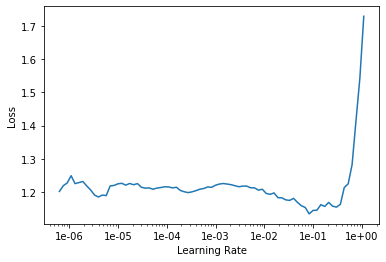

In [26]:
learn.recorder.plot()

In [30]:
learn.fit_one_cycle(1, 2e-02, moms=(0.8,0.7))
#65.9

epoch,train_loss,valid_loss,accuracy,time
0,0.617810,0.610092,0.645777,18:15


In [29]:
learn.save(path/'first_FD_LMC')

In [11]:
learn.load(path/'first_FD_LMC');

In [18]:
learn.freeze_to(-2)
learn.fit_one_cycle(2, slice(1e-2/(2.6**4),1e-2), moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,time
0,0.370214,0.561735,0.746594,18:45
1,0.299656,0.606928,0.749319,19:21


In [19]:
learn.save(path/'second_FD_LMC')

In [12]:
learn.load(path/'second_FD_LMC');

In [12]:
learn.freeze_to(-3)
learn.fit_one_cycle(1, slice(5e-3/(2.6**4),5e-3), moms=(0.8,0.7),wd=0.3)
#77.6
#run it 2-3 times more

epoch,train_loss,valid_loss,accuracy,time
0,0.183098,0.702280,0.760218,20:17


In [14]:
learn.save(path/'third_FD_LMC')

In [11]:
learn.load(path/'third_FD_LMC');

In [ ]:
#learn.unfreeze()
learn.fit_one_cycle(3, slice(1e-3/(2.6**4),1e-3), moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,time
0,0.090478,0.817791,0.765668,55:39
1,0.092325,0.910829,0.762943,57:19


In [15]:
learn.save(path/'Final_FD_LMC')

In [ ]:
learn.predict("I really loved that movie, it was awesome!")

In [ ]:
help(TextList)

In [ ]:
help(learn.predict)

In [27]:
gc.collect()

7354

In [ ]:
doc(TextDataBunch)